<a href="https://colab.research.google.com/github/anujpanwarma2024/RLMidTermProject/blob/main/RLEndTermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Load with row 6 as header
url = (
    "https://raw.githubusercontent.com/"
    "anujpanwarma2024/RLMidTermProject/main/"
    "Clean%20Untitled%20spreadsheet%20-%20Data%20Tape.csv"
)
df = pd.read_csv(url, skiprows=5)
df = df.loc[:, ~df.columns.str.contains("^Unnamed")]

# Extract interest rate % from Loan Product
df['InterestRatePct'] = (
    df['Loan Product'].astype(str)
      .str.extract(r'(\d+\.?\d*)%\s*$', expand=False)
      .astype(float)
)

# Parse DTI
df['Qualifying DTI'] = pd.to_numeric(df['Qualifying DTI'].astype(str).str.rstrip('%'), errors='coerce')

# Coerce and drop
for col in ['DPD', 'Loan Age', 'Original Loan Amount', 'Current Outstanding Principal']:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=['InterestRatePct','Qualifying DTI','DPD','Loan Age'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Context helper
def extract_context(row):
    return np.array([row['InterestRatePct'], row['DPD'], row['Loan Age']], dtype=np.float32)

print("Phase 1 ready, rows:", len(df))


Phase 1 ready, rows: 240


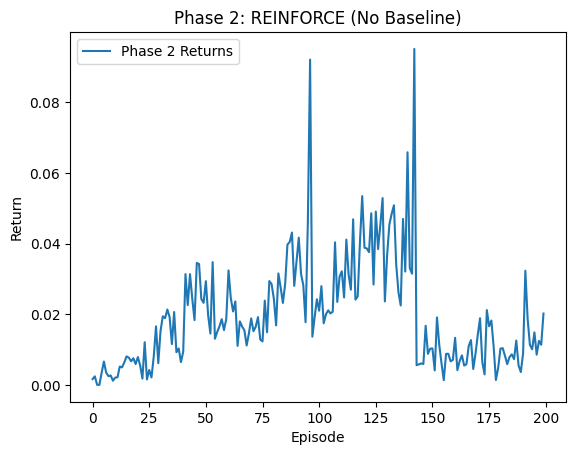

Phase 2 Mean Return: 0.020


In [3]:
# === Phase 2: Base Continuous REINFORCE ===

import numpy as np
import matplotlib.pyplot as plt

# (Re‐use df and extract_context from Phase 1 setup)

# Hyperparameters
num_episodes = 200
alpha = 0.01      # learning rate
sigma = 0.1       # policy std‐dev

# Initialize policy weights
w2 = np.zeros(3, dtype=np.float32)

# Storage for episode returns
returns2 = []

for ep in range(num_episodes):
    xs, actions, rewards = [], [], []

    # Sample an initial loan and context
    row = df.sample(1).iloc[0]
    x = extract_context(row)

    # Rollout one episode (4 steps/quarters)
    for t in range(4):
        mu = w2.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)

        # Compute reward = allocation × interest rate
        r = a * (row['InterestRatePct'] / 100.0)

        xs.append(x)
        actions.append(a)
        rewards.append(r)

        # Move to next loan/context
        row = df.sample(1).iloc[0]
        x = extract_context(row)

    # Monte Carlo return
    G = sum(rewards)
    returns2.append(G)

    # REINFORCE update
    for x_t, a_t in zip(xs, actions):
        grad_logp = ((a_t - w2.dot(x_t)) / sigma**2) * x_t
        w2 += alpha * G * grad_logp

# Plot Phase 2 learning curve
plt.plot(returns2, label='Phase 2 Returns')
plt.title("Phase 2: REINFORCE (No Baseline)")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()

print(f"Phase 2 Mean Return: {np.mean(returns2):.3f}")


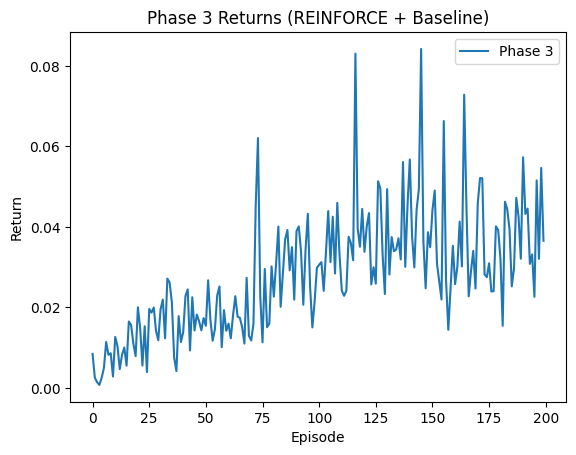

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
num_episodes = 200
alpha = 0.01
sigma = 0.1
beta = 0.1

# Initialize
w3 = np.zeros(3, dtype=np.float32)
b3 = 0.0
returns3 = []

# Phase 3 loop
for ep in range(num_episodes):
    xs, acts, rs = [], [], []
    row = df.sample(1).iloc[0]
    x = extract_context(row)
    for t in range(4):
        mu = w3.dot(x)
        a = np.clip(np.random.normal(mu, sigma), 0, 1)
        # Reward only (no punishment)
        r = a * (row['InterestRatePct']/100.0)
        xs.append(x); acts.append(a); rs.append(r)
        row = df.sample(1).iloc[0]
        x = extract_context(row)
    G = sum(rs)
    returns3.append(G)
    A = G - b3
    for x_t, a_t in zip(xs, acts):
        grad_logp = ((a_t - w3.dot(x_t)) / sigma**2) * x_t
        w3 += alpha * A * grad_logp
    b3 = (1 - beta) * b3 + beta * G

# Plot
plt.plot(returns3, label='Phase 3')
plt.title("Phase 3 Returns (REINFORCE + Baseline)")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()
plt.show()


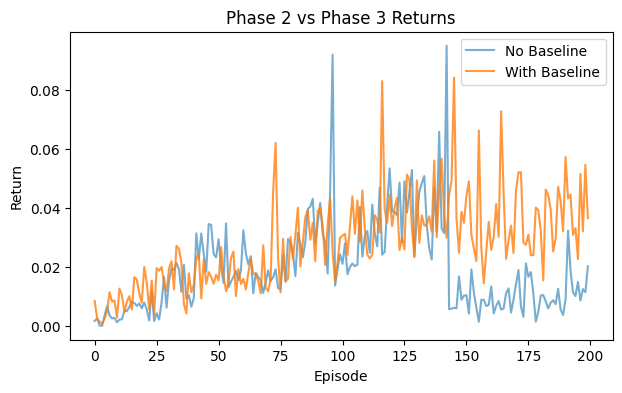

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(returns2, label='No Baseline', alpha=0.6)
plt.plot(returns3, label='With Baseline', alpha=0.8)
plt.title("Phase 2 vs Phase 3 Returns")
plt.xlabel("Episode")
plt.ylabel("Return")
plt.legend()
plt.show()


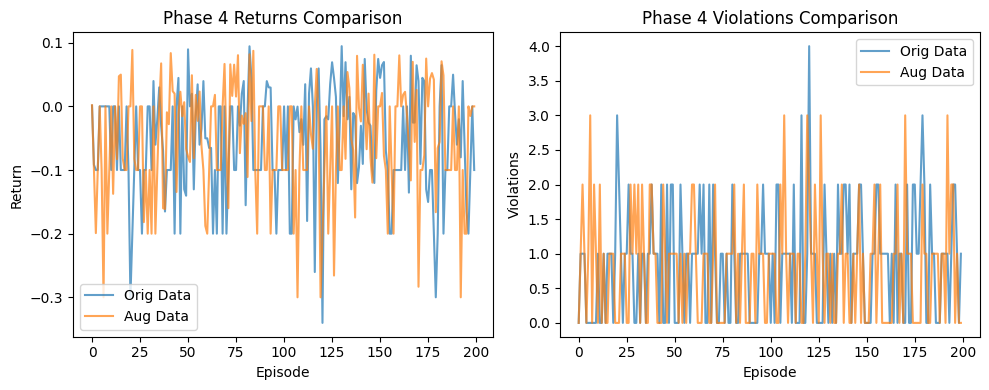

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# === Helper: Phase 4 Training ===
def train_phase4(df_context, num_episodes=200, alpha=0.01, sigma=0.1, beta=0.1, P=0.1, dti_thresh=0.20):
    w = np.zeros(3, dtype=np.float32)
    b = 0.0
    returns, violations = [], []

    def step4(x, a, row):
        reward = a * (row['InterestRatePct']/100.0)
        vio = (row['Qualifying DTI'] > dti_thresh)
        if vio: reward -= P
        next_row = df_context.sample(1).iloc[0]
        return extract_context(next_row), reward, vio

    for ep in range(num_episodes):
        xs, acts, rs = [], [], []
        vio_cnt = 0
        row = df_context.sample(1).iloc[0]; x = extract_context(row)
        for t in range(4):
            mu = w.dot(x)
            a = np.clip(np.random.normal(mu, sigma), 0, 1)
            x, r, vio = step4(x, a, row)
            xs.append(x); acts.append(a); rs.append(r); vio_cnt += int(vio)
            row = df_context.sample(1).iloc[0]
        G = sum(rs)
        returns.append(G); violations.append(vio_cnt)
        A = G - b
        for x_t, a_t in zip(xs, acts):
            grad_logp = ((a_t - w.dot(x_t))/sigma**2)*x_t
            w += alpha * A * grad_logp
        b = (1-beta)*b + beta*G

    return np.array(returns), np.array(violations), w

# === 1) Original Phase 4 on your cleaned df ===
returns_orig, viol_orig, w_orig = train_phase4(df, num_episodes=200)

# === 2) Build an “augmented” DataFrame of 10 000 similar contexts ===
df_aug = df.sample(200, replace=True)  # start with some real rows
# now append 10 000 synthetic variants by jittering DTI and interest
syn_list = []
for _ in range(10000):
    base = df.sample(1).iloc[0].copy()
    # jitter DTI uniformly ±0.05, clip to [0,1]
    base['Qualifying DTI'] = np.clip(base['Qualifying DTI'] + np.random.uniform(-0.05, 0.05), 0, 1)
    # jitter interest ±0.5%
    base['InterestRatePct'] = np.clip(base['InterestRatePct'] + np.random.uniform(-0.5,0.5), 0, None)
    syn_list.append(base)
df_aug = pd.concat([df, pd.DataFrame(syn_list)], ignore_index=True)

# === 3) Phase 4 on augmented data ===
returns_aug, viol_aug, w_aug = train_phase4(df_aug, num_episodes=200)

# === 4) Comparison Plots ===
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(returns_orig, label='Orig Data', alpha=0.7)
plt.plot(returns_aug,  label='Aug Data',  alpha=0.7)
plt.title("Phase 4 Returns Comparison")
plt.xlabel("Episode"); plt.ylabel("Return"); plt.legend()

plt.subplot(1,2,2)
plt.plot(viol_orig, label='Orig Data', alpha=0.7)
plt.plot(viol_aug,  label='Aug Data',  alpha=0.7)
plt.title("Phase 4 Violations Comparison")
plt.xlabel("Episode"); plt.ylabel("Violations"); plt.legend()

plt.tight_layout()
plt.show()




IPS Estimate of Expected Return: nan


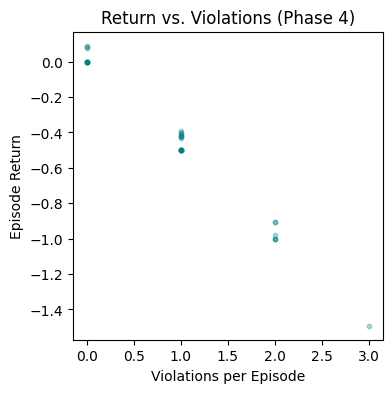

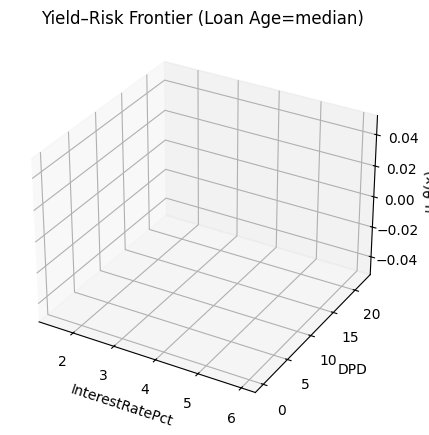

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- 1. Off‐Policy Evaluation (IPS) ---
# Draw 1000 held‐out contexts
df_eval = df.sample(200, random_state=42).reset_index(drop=True)

ips_estimates = []
for _, row in df_eval.iterrows():
    x = extract_context(row)
    # 1) Sample an action under the *logging* policy (uniform[0,1])
    a_log = np.random.rand()
    # 2) Compute reward that action would’ve gotten
    r = a_log * (row['InterestRatePct']/100.0)
    # 3) Compute densities under target policy πθ (Gaussian) and logging (uniform)
    mu = w4.dot(x)
    p_target = norm.pdf(a_log, loc=mu, scale=sigma)        # πθ(a|x)
     p_target = max(p_target, 1e-8)    # floor it
    ips_estimates.append(r * p_target)
ips_value = np.mean(ips_estimates)
print("IPS Estimate:", ips_value)
    p_logging = 1.0                                        # uniform on [0,1]
    # 4) IPS weight
    ips_estimates.append(r * (p_target / p_logging))

ips_value = np.mean(ips_estimates)
print(f"IPS Estimate of Expected Return: {ips_value:.4f}")

# --- 2. Return vs. Violation Trade‐off Scatter ---
plt.figure(figsize=(4,4))
plt.scatter(violations4, returns4, alpha=0.3, s=10, color='teal')
plt.xlabel("Violations per Episode")
plt.ylabel("Episode Return")
plt.title("Return vs. Violations (Phase 4)")
plt.show()

# --- 3. Yield–Risk Frontier Surface Plot ---
# Fix Loan Age at its median; vary InterestRatePct and DPD
grid_size = 50
irp = np.linspace(df['InterestRatePct'].min(), df['InterestRatePct'].max(), grid_size)
dpd = np.linspace(df['DPD'].min(), df['DPD'].max(), grid_size)
LA_med = df['Loan Age'].median()

IR, D = np.meshgrid(irp, dpd)
MU = np.zeros_like(IR)

for i in range(grid_size):
    for j in range(grid_size):
        x = np.array([IR[i,j], D[i,j], LA_med], dtype=np.float32)
        MU[i,j] = w4.dot(x)  # policy mean allocation

fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(IR, D, MU, cmap='viridis', edgecolor='none')
ax.set_xlabel("InterestRatePct")
ax.set_ylabel("DPD")
ax.set_zlabel("μ_θ(x)")
ax.set_title("Yield–Risk Frontier (Loan Age=median)")
plt.show()
